# Evaluate on experimental data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib import pipeline
from lib import data_gen
import importlib
importlib.reload(pipeline)
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.data_generation import ReflectivityGenerator
from mlreflect.training import InputPreprocessor, OutputPreprocessor
import tensorflow as tf
from tensorflow import keras
from mlreflect.curve_fitter import CurveFitter
from mlreflect.data_generation import interp_reflectivity

PARAMETERS = ["Film_thickness", "Film_roughness", "Film_sld"]
plt.close('all')

In [2]:
noise_level=0.2
BATCH_SIZE=512

In [3]:
# model_cnn = keras.models.load_model(
#     'models/0.001_0.0_100_100_50_12_8_512_20220627-183255')
model_cnn = keras.models.load_model(
    'models/0.001_0.2_100_100_50_12_8_512_20220705-194014')

mean_labels, std_labels = np.loadtxt(
    "data/mean_labels.csv"), np.loadtxt("data/std_labels.csv")
mean_data, std_data = np.loadtxt(
    f"data/mean_data_{noise_level}.csv"), np.loadtxt(f"data/std_data_{noise_level}.csv")

In [4]:
def visualize_experimental_performance():

    q_values_used_for_training = DefaultTrainedModel().q_values
    sample = DefaultTrainedModel().sample
    model_mlp = DefaultTrainedModel()
    fig_boxplot, axs_boxplot = plt.subplots(1, sharey=True)
    fig_boxplots_param_errors, axs_boxplots_param_errors = plt.subplots(
        1, 3, figsize=(10, 5))
    fig_boxplots_param_errors_rel, axs_boxplots_param_errors_rel = plt.subplots(
    1, 3, figsize=(10, 5))
    fig_boxplot.suptitle("Statistical comparison")
    param_clean_test_list=[]
    test_refl_lst, test_q_values_lst, test_lables_lst = data_gen.iterate_experiments()
    for experiment in test_lables_lst:
        for param_set in zip(np.atleast_1d(experiment[0]).tolist(), np.atleast_1d(experiment[1]).tolist(), np.atleast_1d(experiment[2]).tolist()):
            param_clean_test_list.append(param_set)
    th_lst_cnn, rh_lst_cnn, sld_lst_cnn, mse_errors_cnn = pipeline.test_on_exp_data_pipeline(
        test_refl_lst, test_q_values_lst, test_lables_lst, q_values_used_for_training, "CNN", sample, model_cnn, noise_level, mean_labels, std_labels, mean_data, std_data)
    th_lst_mlp, rh_lst_mlp, sld_lst_mlp, mse_errors_mlp = pipeline.test_on_exp_data_pipeline(
        test_refl_lst, test_q_values_lst, test_lables_lst, q_values_used_for_training, "MLP", sample, model_mlp, noise_level, mean_labels, std_labels, mean_data, std_data)
    
    for param_idx, (param_lst_cnn, param_lst_mlp) in enumerate(zip([th_lst_cnn, rh_lst_cnn, sld_lst_cnn], [th_lst_mlp, rh_lst_mlp, sld_lst_mlp])):
        axs_boxplots_param_errors[param_idx].boxplot(
            [param_lst_mlp, param_lst_cnn], positions=[1, 2], showfliers=False)
            
        nominator_cnn=np.array(param_lst_cnn)
        nominator_mlp=np.array(param_lst_mlp)
        denominator=np.array(param_clean_test_list)[:,param_idx]
        axs_boxplots_param_errors_rel[param_idx].boxplot(
            [np.absolute(100*nominator_mlp/denominator), np.absolute(100*nominator_cnn/denominator)],  positions=[1, 2], showfliers=False
        )
        axs_boxplots_param_errors_rel[param_idx].set_title(PARAMETERS[param_idx])
        axs_boxplots_param_errors_rel[param_idx].set_xticklabels(["MLP", "CNN"])
    for ax_idx, ax in enumerate(axs_boxplots_param_errors):
        axs_boxplots_param_errors[ax_idx].set_xticklabels(["MLP", "CNN"])
        axs_boxplots_param_errors[ax_idx].set_title(PARAMETERS[ax_idx])
    axs_boxplot.boxplot(
        [mse_errors_mlp, mse_errors_cnn], showfliers=False)
    axs_boxplot.set_xticklabels(["MLP", "CNN"])

    fig_boxplot.suptitle(f"MSE on parameters for 240 experimental curves")
    fig_boxplots_param_errors.suptitle(
        f"Parameter's absolute errors (240 exp. curves), trained on noise (MLP: 0.3, CNN: {noise_level})")
    fig_boxplots_param_errors_rel.suptitle(
        f"Relative absolute errors"
    )

CNN
Exp median param error: (33.44060238138852, 3.8336314573256214, 0.849960758597443)
Exp mse median: 0.028277897275984287
MLP
Exp median param error: (6.420808236166586, 1.7280227407821087, 0.7923725134125156)
Exp mse median: 0.029150230810046196


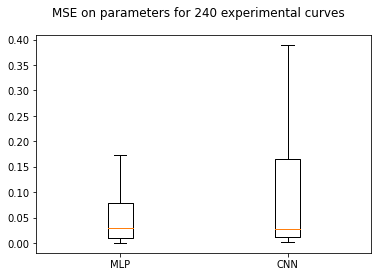

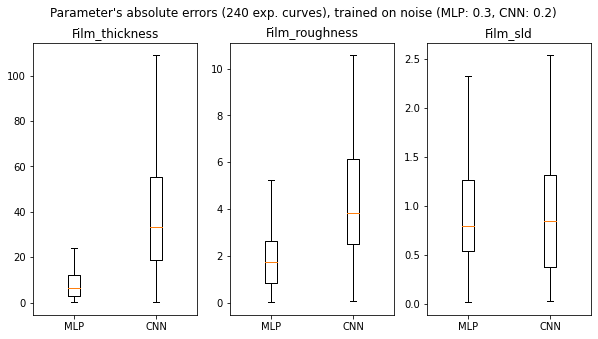

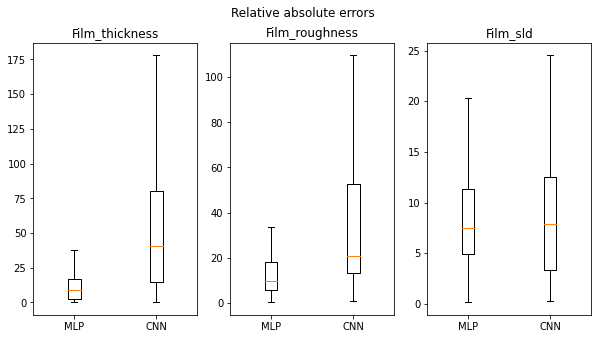

In [5]:
visualize_experimental_performance()